In [1]:
from config import cfg
from resnet20 import ResNet20
from dataset_cifar10 import CIFAR10
import pruning
import test
from utils import load_model, plot, plot_F_with_axes
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
import re
from IPython.display import HTML
from pruning import prune_layers_by_regexp, prune_layers_by_names
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
import json
from tabulate import tabulate

# Скачать датасет CIFAR10
### !Путь до данного датасета можно изменить в ручную в файле config.py

In [2]:
ds_train = CIFAR10(cfg.path_to_dataset, cfg, transform_mode='train')
dl_train = DataLoader(ds_train, batch_size=cfg.batch_size, shuffle=True)
ds_test = CIFAR10(cfg.path_to_dataset, cfg, work_mode='test', transform_mode='test')
dl_test = DataLoader(ds_test, batch_size=cfg.batch_size, shuffle=True)

# Реализовать и обучить архитектуру ResNet20

In [2]:
from torchsummary import summary
model = ResNet20().to(cfg.device)
optimizer = torch.optim.SGD(model.parameters(), lr=cfg.lr, momentum=cfg.momentum, weight_decay=cfg.weight_decay)
model, optimizer, start_epoch, max_accuracy = load_model(os.path.join(cfg.path_to_saves, cfg.name_save),model,cfg,optimizer)
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
        BasicBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
       BasicBlock-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

# Проверка точности обученной модели

Evaluate on test data
Epoch: 44. Batchs 0 of 79.
Epoch: 44. Batchs 50 of 79.
Epoch:44. test accuracy 0.9014


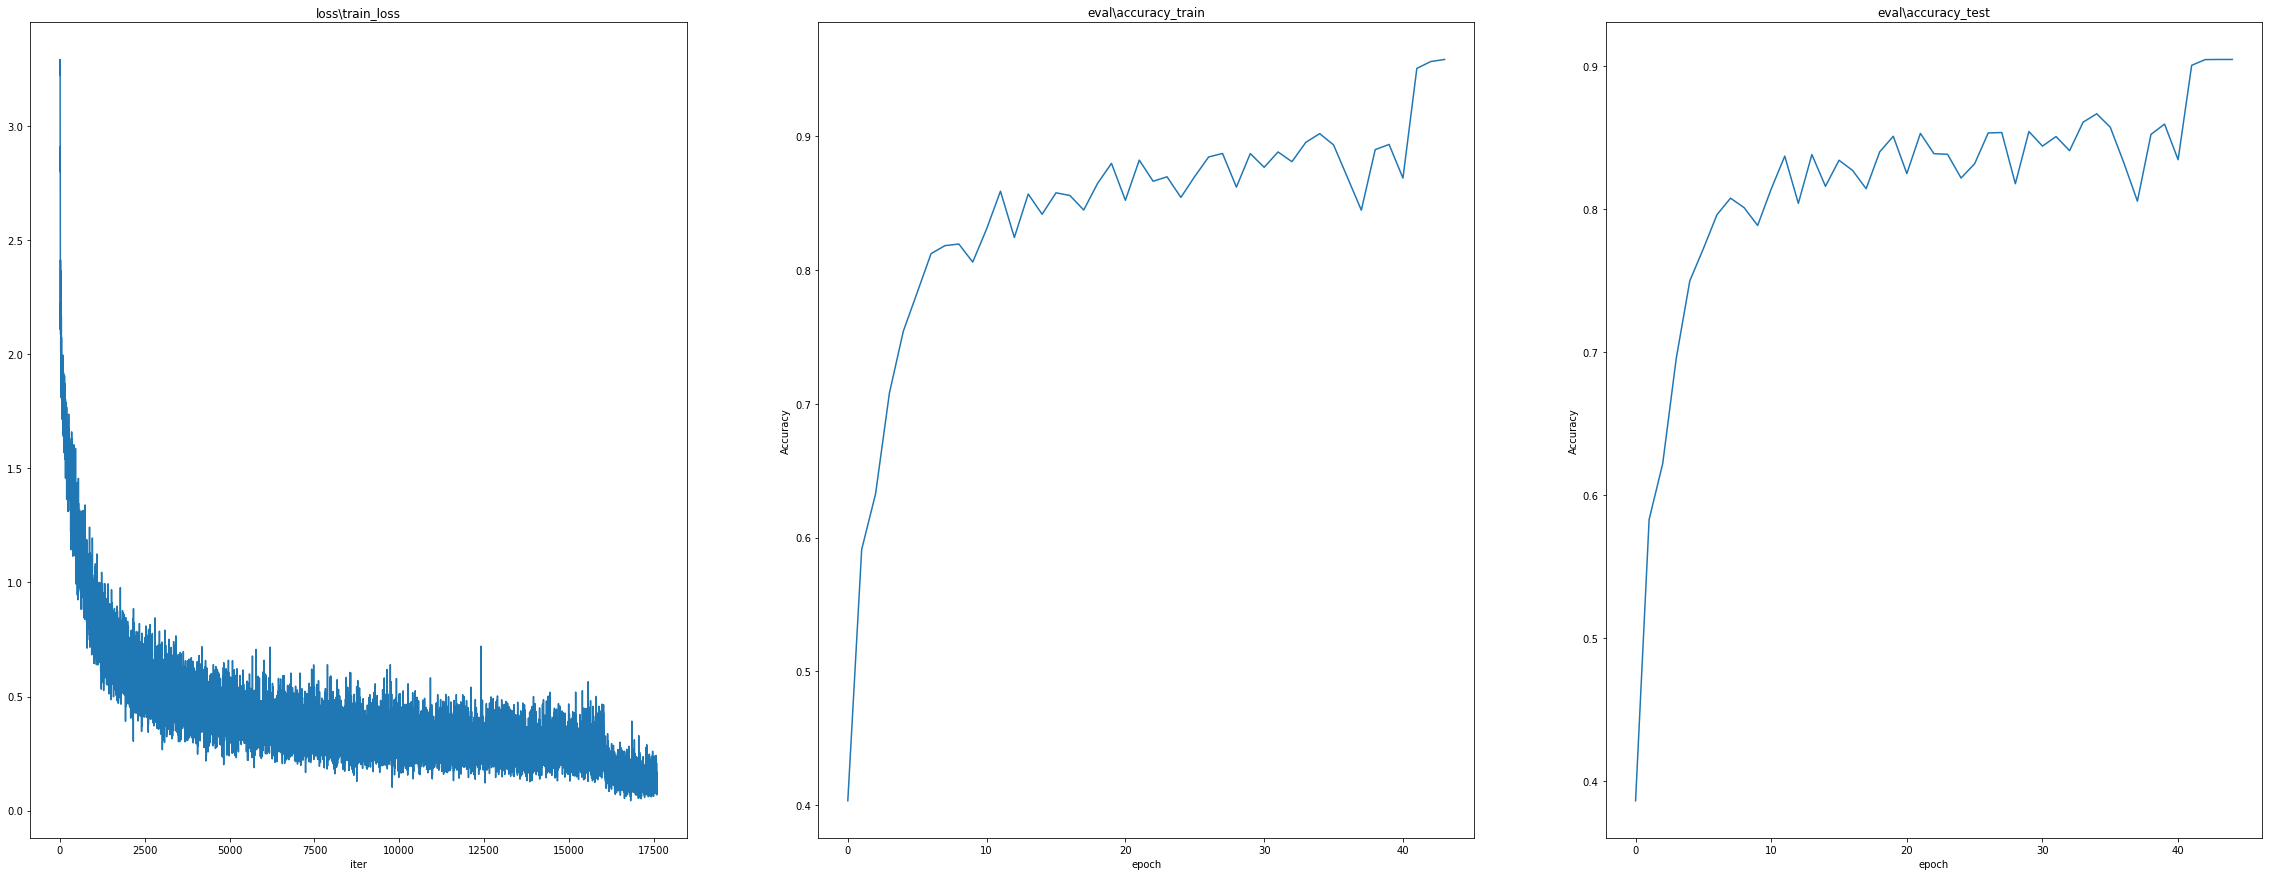

In [8]:
test.test(model,cfg,start_epoch)
fig, axes = plt.subplots(1,3,figsize=(40,15))
plot('loss\\train_loss', axes[0],cfg, 'iter')
plot('eval\\accuracy_train',axes[1],cfg,'epoch','Accuracy')
plot('eval\\accuracy_test',axes[2],cfg,'epoch','Accuracy')
plt.show()

# Реализовать filter-level метод pruning'а.

Для оценки оптимальности количества кластеров будет использовано следующие отношение: $$F = \frac{\frac{unique\_params}{conv\_params}}{accuracy},$$ где $unique\_params$ - это количество уникальных параметров внутри всех центройд, $conv\_params$ - это сколько всего параметров в сверточном фильтре, $accuracy$ - это точность всей сети после замены в данном слое сверточных фильтров на центройды кластеров. Чем выше данная метрика тем выгоднее обмен количества параметров на точность. Она будет убывать с увеличением количества кластеров и поэтому нас будут интересовать локальные максимумы. С помощью этой метрики можно найти количество кластеров, при которых точность упадет не значительно в сравнение с уменьшением количества уникальных параметров, и после чего можно будет дообучить модель, чтобы восполнить потерянную точность.

## Поиск оптимального значения кластеров для каждого слоя.

In [ ]:
store = {}

In [5]:
model = ResNet20().to(cfg.device)
model, _, start_epoch, max_accuracy = load_model(os.path.join(cfg.path_to_saves, cfg.name_save),model,cfg)

for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        store[name] = [[],[]]
        print(f'Layer {name}. {module.weight.size(0)} filters')
        for n in range(2,module.weight.size(0)+1):
            pruned_model, count_changed_layers, unique_params, conv_params = prune_layers_by_regexp(name,n,model,cfg,kmeans,kmeans_plusplus_initializer)
            accuracy = test.test(pruned_model,cfg,with_print=False)
            store[name][0].append(unique_params/conv_params)
            store[name][1].append(accuracy)
with open('store.json', 'w') as f:
    json.dump(store, f)

Layer conv1. 16 filters
Layer layer1.0.conv1. 16 filters
Layer layer1.0.conv2. 16 filters
Layer layer1.1.conv1. 16 filters
Layer layer1.1.conv2. 16 filters
Layer layer1.2.conv1. 16 filters
Layer layer1.2.conv2. 16 filters
Layer layer2.0.conv1. 32 filters
Layer layer2.0.conv2. 32 filters
Layer layer2.1.conv1. 32 filters
Layer layer2.1.conv2. 32 filters
Layer layer2.2.conv1. 32 filters
Layer layer2.2.conv2. 32 filters
Layer layer3.0.conv1. 64 filters
Layer layer3.0.conv2. 64 filters
Layer layer3.1.conv1. 64 filters
Layer layer3.1.conv2. 64 filters
Layer layer3.2.conv1. 64 filters
Layer layer3.2.conv2. 64 filters


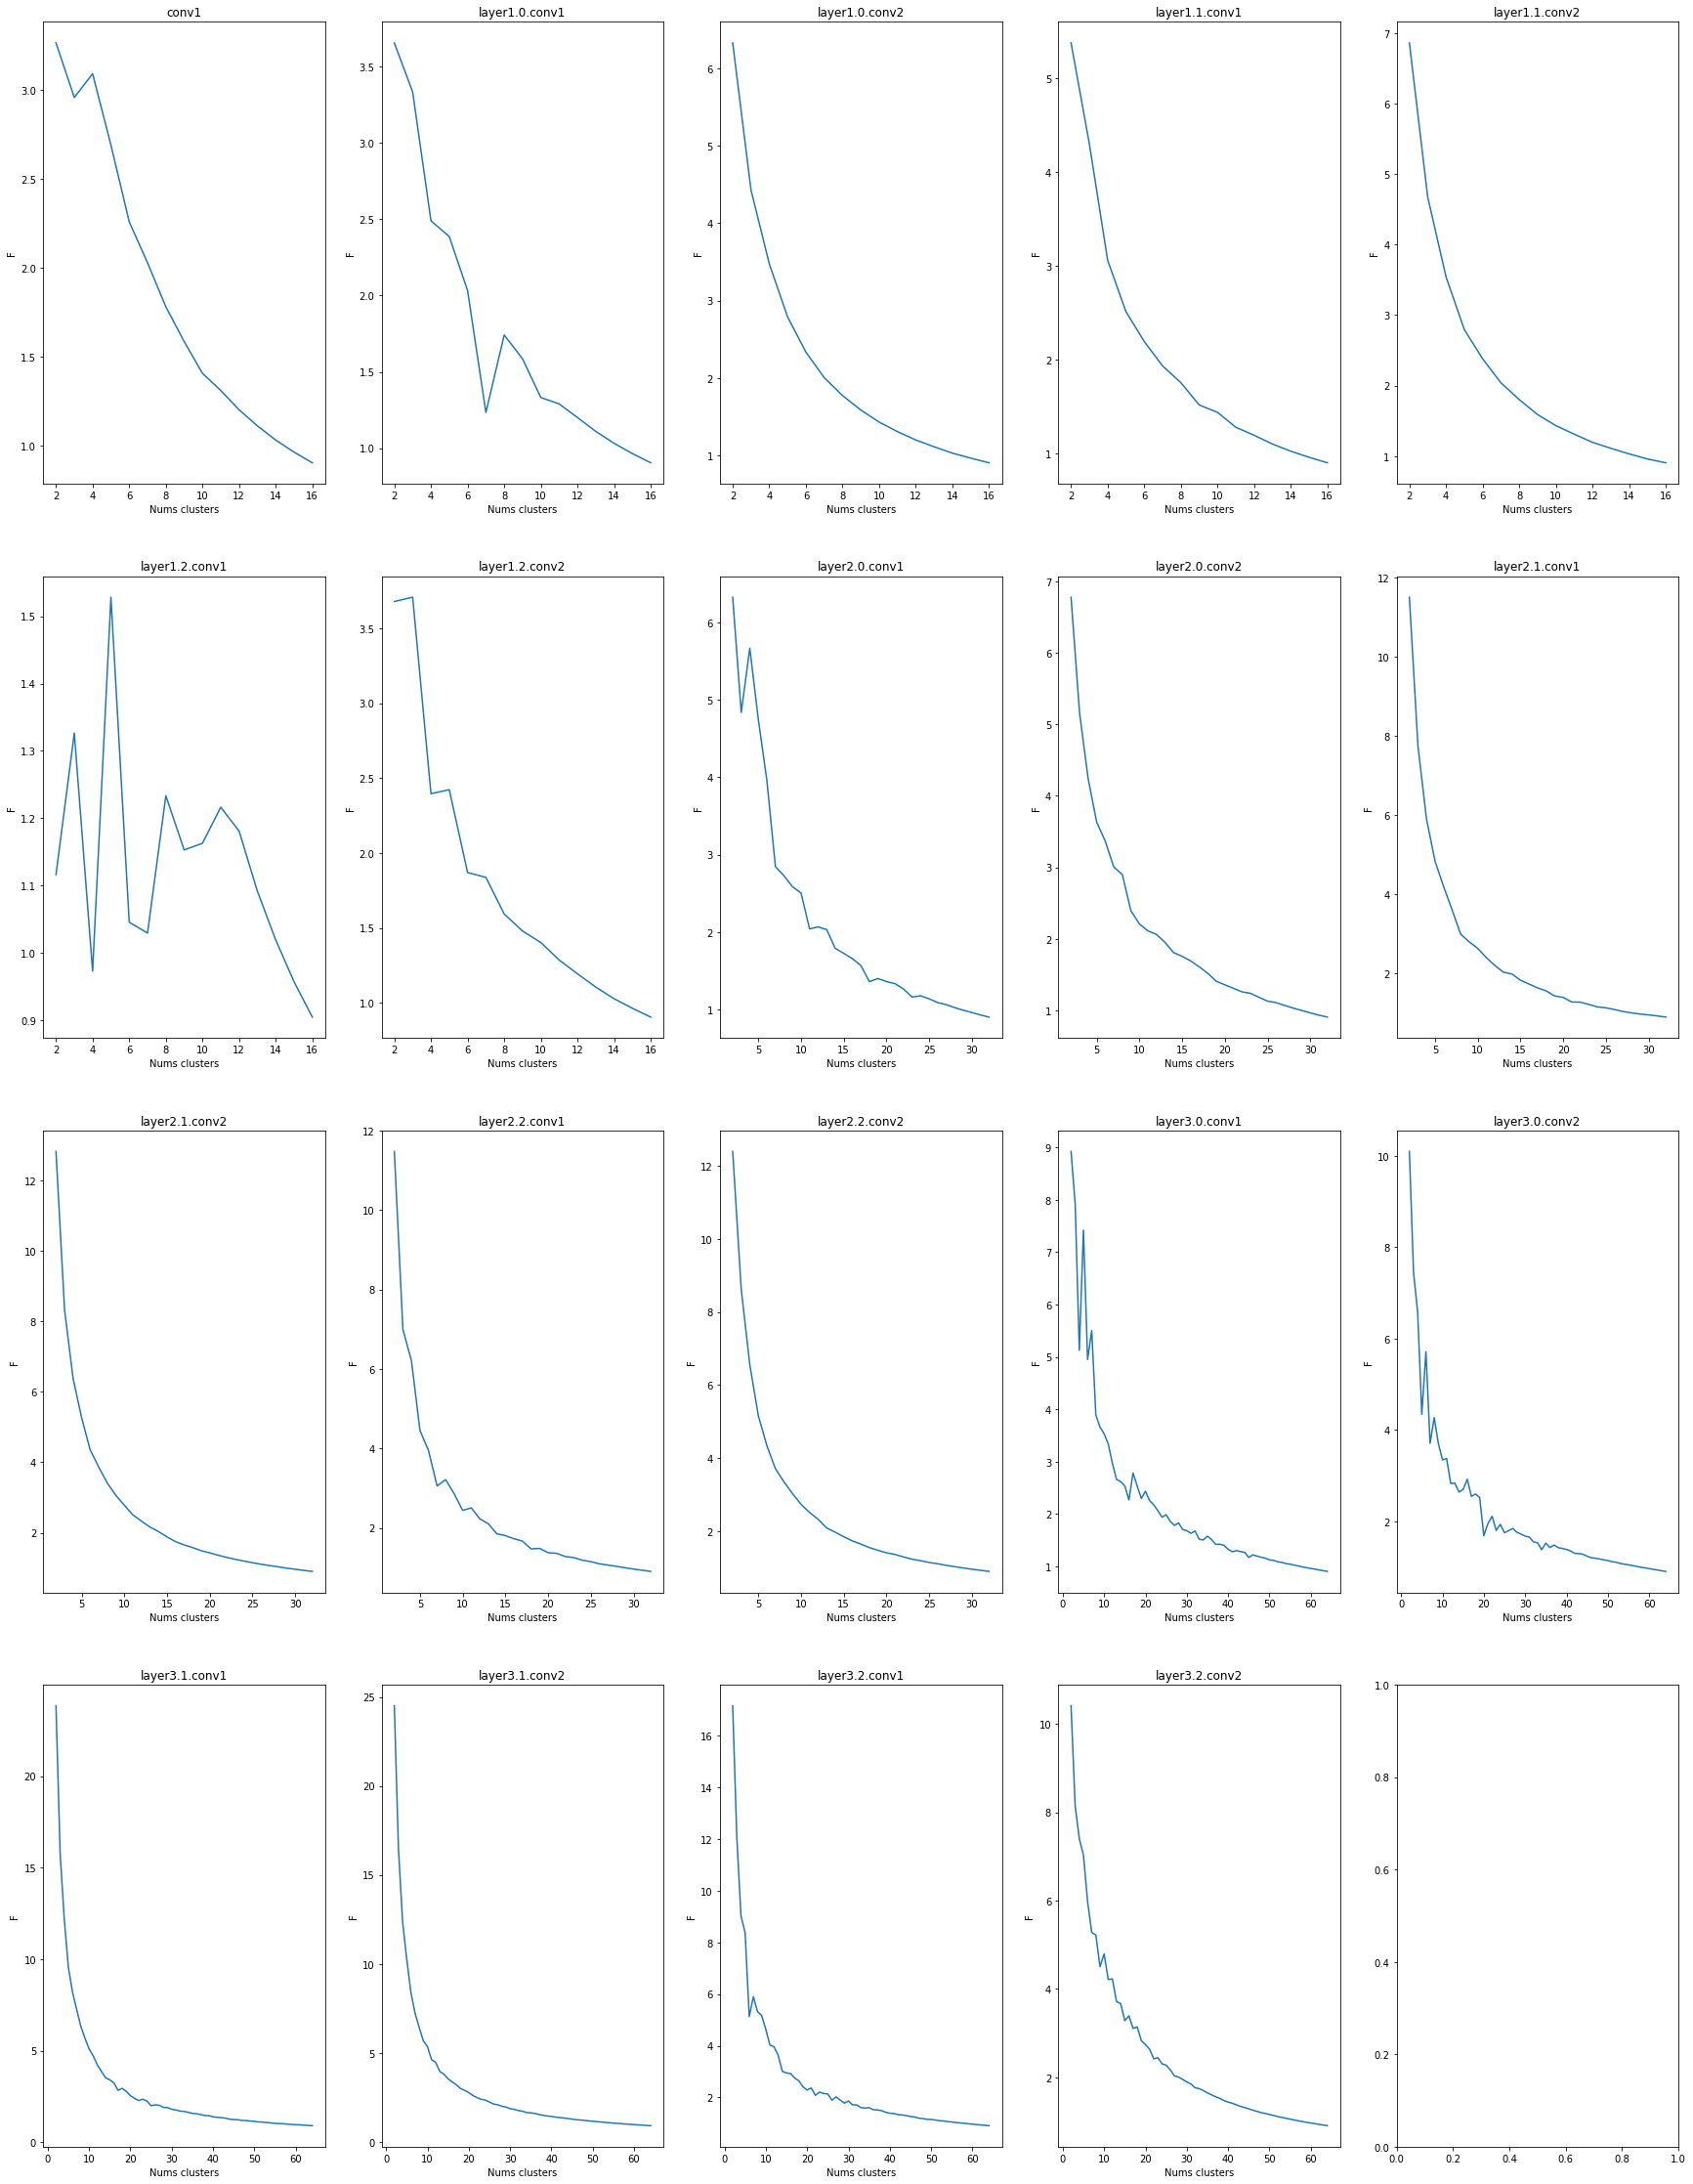

In [33]:
fig, axes = plt.subplots(4, 5,  figsize=(30,40))

names = list(store.keys())
idx = 0
for row in range(6):
    for column in range(5):
        name = names[idx]
        length = len(store[name][0])
        accuracy = np.array(store[name][1])
        uniq_params = np.array(store[name][0])
        axes[row, column].plot(np.arange(2,length+2),accuracy/uniq_params)
        axes[row,column].set_xlabel('Nums clusters')
        axes[row,column].set_ylabel('F')
        axes[row,column].set_title(name)
        idx += 1
        if idx == len(names):
            break
    if idx == len(names):
                break
plt.show()


Как можно заметить на некоторых графиках явных локальных максимумов нет, поэтому выбор количества кластеров в данных сверточных слоях можно сделать основываясь на том, какое соотношения нас устраивает больше всего.

## Использование одинакового количества кластеров для каждого слоя.
В данном эксперименте, я считаю, нужно выполнить деление на блоки на основании количества сверточных фильтров в слоях, потому что если для слоя,где 16 сверточных фильтров, 8 кластеров это будет ещё приемлемо, то для слоя, где 64 фильтра, это будет ужасно. И, так как количество сверточных фильтров может быть 16, 32 и 64, поделим на основании этого количества эти фильтры на три группы.

In [86]:
store_groups = {}


In [87]:
def cluster_filters_of_group_layers(name, store_groups, nums_clusters):
    store_groups[name] = [[],[]]
    for n in range(2,nums_clusters+1):
        print(f'Nums clusters: {n}')
        pruned_model, count_changed_layers, unique_params, conv_params = prune_layers_by_regexp(name,n,model,cfg,kmeans,kmeans_plusplus_initializer)
        accuracy = test.test(pruned_model,cfg,with_print=False)
        store_groups[name][0].append(unique_params/conv_params)
        store_groups[name][1].append(accuracy)

### Layer1 (16 сверточных фильтров)

In [89]:
name='layer1'
cluster_filters_of_group_layers(name,store_groups,16)

Nums clusters: 2
Nums clusters: 3
Nums clusters: 4
Nums clusters: 5
Nums clusters: 6
Nums clusters: 7
Nums clusters: 8
Nums clusters: 9
Nums clusters: 10
Nums clusters: 11
Nums clusters: 12
Nums clusters: 13
Nums clusters: 14
Nums clusters: 15
Nums clusters: 16


### Layer2 (32 сверточных фильтров)

In [90]:
name='layer2'
cluster_filters_of_group_layers(name,store_groups,32)

Nums clusters: 2
Nums clusters: 3
Nums clusters: 4
Nums clusters: 5
Nums clusters: 6
Nums clusters: 7
Nums clusters: 8
Nums clusters: 9
Nums clusters: 10
Nums clusters: 11
Nums clusters: 12
Nums clusters: 13
Nums clusters: 14
Nums clusters: 15
Nums clusters: 16
Nums clusters: 17
Nums clusters: 18
Nums clusters: 19
Nums clusters: 20
Nums clusters: 21
Nums clusters: 22
Nums clusters: 23
Nums clusters: 24
Nums clusters: 25
Nums clusters: 26
Nums clusters: 27
Nums clusters: 28
Nums clusters: 29
Nums clusters: 30
Nums clusters: 31
Nums clusters: 32


### Layer3 (64 сверточных фильтров)

In [91]:
name='layer3'
cluster_filters_of_group_layers(name,store_groups,64)

Nums clusters: 2
Nums clusters: 3
Nums clusters: 4
Nums clusters: 5
Nums clusters: 6
Nums clusters: 7
Nums clusters: 8
Nums clusters: 9
Nums clusters: 10
Nums clusters: 11
Nums clusters: 12
Nums clusters: 13
Nums clusters: 14
Nums clusters: 15
Nums clusters: 16
Nums clusters: 17
Nums clusters: 18
Nums clusters: 19
Nums clusters: 20
Nums clusters: 21
Nums clusters: 22
Nums clusters: 23
Nums clusters: 24
Nums clusters: 25
Nums clusters: 26
Nums clusters: 27
Nums clusters: 28
Nums clusters: 29
Nums clusters: 30
Nums clusters: 31
Nums clusters: 32
Nums clusters: 33
Nums clusters: 34
Nums clusters: 35
Nums clusters: 36
Nums clusters: 37
Nums clusters: 38
Nums clusters: 39
Nums clusters: 40
Nums clusters: 41
Nums clusters: 42
Nums clusters: 43
Nums clusters: 44
Nums clusters: 45
Nums clusters: 46
Nums clusters: 47
Nums clusters: 48
Nums clusters: 49
Nums clusters: 50
Nums clusters: 51
Nums clusters: 52
Nums clusters: 53
Nums clusters: 54
Nums clusters: 55
Nums clusters: 56
Nums clusters: 57


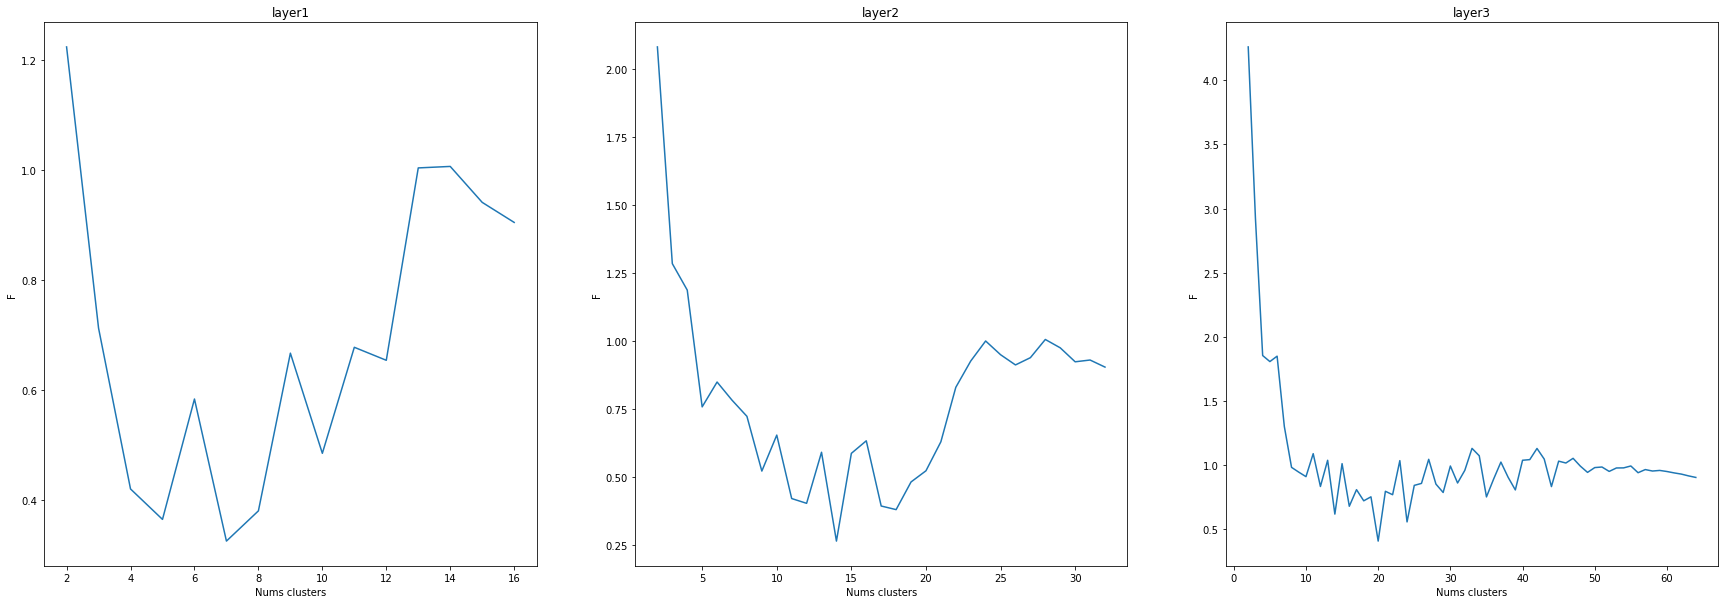

In [47]:
fig, axes = plt.subplots(1, 3,  figsize=(30,10))

names = list(store_groups.keys())
for column in range(3):
    name = names[column]
    length = len(store_groups[name][0])
    accuracy = np.array(store_groups[name][1])
    uniq_params = np.array(store_groups[name][0])
    axes[column].plot(np.arange(2,length+2),accuracy/uniq_params)
    axes[column].set_xlabel('Nums clusters')
    axes[column].set_ylabel('F')
    axes[column].set_title(name)
plt.show()

Как можно заметить данный эксперимент является более показательным. По первому и второму графику можно сделать вывод, что разбиение будут очень выгодными с точки зрения уменьшения уникальных параметров на 13 кластеров в случае кластеризации фильтров в первой группе и в случае разбиения фильтров на 24 кластера во второй группе.

In [93]:
table_layers = []
for name, v in store_groups.items():
    for i in range(len(v[0])):
        table_layers.append([name,i+2,v[0][i], v[1][i]])
print(tabulate(table_layers,headers=['group','nums clusters','unique_params/conv_params','accuracy']))

group      nums clusters    unique_params/conv_params    accuracy
-------  ---------------  ---------------------------  ----------
layer1                 2                     0.125         0.0998
layer1                 3                     0.1875        0.1106
layer1                 4                     0.25          0.0932
layer1                 5                     0.3125        0.0966
layer1                 6                     0.375         0.1181
layer1                 7                     0.4375        0.1637
layer1                 8                     0.5           0.1947
layer1                 9                     0.5625        0.1244
layer1                10                     0.625         0.1927
layer1                11                     0.6875        0.697
layer1                12                     0.75          0.7633
layer1                13                     0.8125        0.7515
layer1                14                     0.875         0.8604
layer1     

После получения более подробной статистики выводы сделанные на основании графиков подтвердились, в случае работы с первой группой при разбиении на 13 кластеров точность упадёт на 9% в то время как уникальных параметров станет в 4/5 раза меньше. А во второй группе при разбиении фильтров на 24 кластера точности падает на 15%, а количество параметров снижается в 3/4 раза. В случае третий группы, как можно заметить, явно выгодного обмена там нет.
Для самого первого сверточного слоя эксперимент не проводился, потому что он участвовал в предыдущем эксперименте с выбором количества кластеров для каждого слоя и как можно было заметить он не дал интересных результатов.

## Использование в первых и последних слоя большего числа кластеров, чем в остальных

В данном эксперименте количество кластеров для фильтров сверточных слоёв первой группы за исключением layer1.0.conv1 и layer1.0.conv2 задается одинаковое, для фильтров второй группы количество кластеров одинаковое, а для фильтров третий группы оно тоже одинаково за исключением двух последних слоёв.
В store_exp_3 количество кластеров будет задавать следующим образом [layer1, layer2, layer3, conv1, layer1.0.conv1, layer1.0.conv2, layer3.2.conv1, layer3.2.conv2].

In [3]:
cfg.name_save = 'best_checkpoint'
model, optimizer, start_epoch, max_accuracy = load_model(os.path.join(cfg.path_to_saves, cfg.name_save),model,cfg,optimizer)
test.test(model,cfg)

Evaluate on test data
Epoch: None. Batchs 0 of 79.
Epoch: None. Batchs 50 of 79.
Epoch:None. test accuracy 0.9087


0.9087

In [4]:
store_exp_3 = {}

In [5]:
loss_params = 0
layer1_nb_clusters = 12
layer2_nb_clusters = 28
layer3_nb_clusters = 58
first_conv = 16
layer1_0_conv1 = 15
layer1_0_conv2 = 15
layer3_2_conv1 = 52
layer3_2_conv2 = 52


regexp = 'layer2'
pruned_model, count_changed_layers, unique_params, conv_params = prune_layers_by_regexp(regexp,layer2_nb_clusters,model,cfg,kmeans,kmeans_plusplus_initializer)
loss_params += conv_params - unique_params
names_and_nb_clusters = {
    'conv1': first_conv,
    'layer1.0.conv1': layer1_0_conv1,
    'layer1.0.conv2': layer1_0_conv2,

    'layer1.1.conv1': layer1_nb_clusters,
    'layer1.1.conv2': layer1_nb_clusters,
    'layer1.2.conv1': layer1_nb_clusters,
    'layer1.2.conv2': layer1_nb_clusters,

    'layer3.0.conv1': layer3_nb_clusters,
    'layer3.0.conv2': layer3_nb_clusters,
    'layer3.1.conv1': layer3_nb_clusters,
    'layer3.1.conv2': layer3_nb_clusters,


    'layer3.2.conv1': layer3_2_conv1,
    'layer3.2.conv2':  layer3_2_conv2
}
pruned_model, count_changed_layers, unique_params, conv_params = prune_layers_by_names(names_and_nb_clusters,pruned_model,cfg,kmeans,kmeans_plusplus_initializer)
loss_params += conv_params - unique_params
accuracy = test.test(pruned_model,cfg,with_print=False)
store_exp_3[f'{layer1_nb_clusters} {layer2_nb_clusters} {layer3_nb_clusters} {first_conv} {layer1_0_conv1} {layer1_0_conv2}' \
            f' {layer3_2_conv1} {layer3_2_conv2}'] = [accuracy, loss_params]



In [105]:
from tabulate import tabulate
from IPython.display import HTML, display
table = []
for k,v in store_exp_3.items():
    table.append(list(map(int,k.split()))+v)
display(HTML(tabulate(table,headers=['layer1','layer2','layer3','first_conv','layer1_0_conv1','layer1_0_conv2','layer3_2_conv1',
                              'layer3_2_conv2','accuracy','loss_params'],showindex="always",tablefmt='html')))

,layer1,layer2,layer3,first_conv,layer1_0_conv1,layer1_0_conv2,layer3_2_conv1,layer3_2_conv2,accuracy,loss_params
0,15,24,48,12,15,15,60,61,0.3398,49962
1,15,24,48,14,15,15,60,61,0.3553,49908
2,15,24,48,16,15,15,60,61,0.3617,49854
3,12,24,48,16,15,15,60,61,0.3298,51582
4,10,24,48,16,15,15,60,61,0.1958,52734
5,16,24,48,16,15,15,60,61,0.3646,49278
6,16,20,48,16,15,15,60,61,0.3266,55612
7,16,28,48,16,15,15,60,61,0.672,42942
8,16,28,58,16,15,15,60,61,0.8178,22788
9,16,24,58,16,15,15,60,61,0.5476,29124


1) При проведении данного эксперимента было замечено, что количество кластеров в сверточных слоях второй группы тоже должно быть достаточно большим(эксперимент 8 и 21).
2) Количество кластеров в последних двух слоях можно снизить без большой потери качества (эксперимент 12-17).
3) В первых двух слоях первой группы можно незначительно снизить количество кластеров (эксперимент 17-20)
4) Количество кластеров в слоях третий группы(за исключением двух последних) сильно уменьшать не стоит (эксперимент 22).


# Дообучение модели
Для дообучения была взять модель из эксперимента №17

In [6]:

test.test(pruned_model,cfg)

state = {
    'model': pruned_model.state_dict(),
    'epoch': start_epoch-1,
    'best_accuracy': max_accuracy,
    'opt': optimizer.state_dict()
}
torch.save(state, os.path.join(cfg.path_to_saves,f'pruned_model'))
summary(pruned_model,(3,32,32))

Evaluate on test data
Epoch: None. Batchs 0 of 79.
Epoch: None. Batchs 50 of 79.
Epoch:None. test accuracy 0.7189
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
        BasicBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
       BasicBlock-12           [-1, 16, 32, 32]      

In [7]:

cfg.name_save = 'pruned_model'
from train import train
loss_func = torch.nn.functional.cross_entropy
pruned_model,optimizer, start_epoch, max_accuracy = load_model(os.path.join(cfg.path_to_saves, cfg.name_save),model,cfg,optimizer)
for name, module in pruned_model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        module.weight.requires_grad = False

manual_load = {
    'optimizer':optimizer,
    'epoch': start_epoch,
    'max_accuracy':max_accuracy
}
train(pruned_model,loss_func,optimizer,cfg,manual_load)



Train
Epoch: 45. Iteration 0 of 391.
Epoch: 45. Iteration 50 of 391.
Epoch: 45. Iteration 100 of 391.
Epoch: 45. Iteration 150 of 391.
Epoch: 45. Iteration 200 of 391.
Epoch: 45. Iteration 250 of 391.
Epoch: 45. Iteration 300 of 391.
Epoch: 45. Iteration 350 of 391.
Evaluate on train data
Epoch: 45. Batchs 0 of 391.
Epoch: 45. Batchs 50 of 391.
Epoch: 45. Batchs 100 of 391.
Epoch: 45. Batchs 150 of 391.
Epoch: 45. Batchs 200 of 391.
Epoch: 45. Batchs 250 of 391.
Epoch: 45. Batchs 300 of 391.
Epoch: 45. Batchs 350 of 391.
Epoch:45. train accuracy 0.93148
Evaluate on test data
Epoch: 45. Batchs 0 of 79.
Epoch: 45. Batchs 50 of 79.
Epoch:45. test accuracy 0.8863
Train
Epoch: 46. Iteration 0 of 391.
Epoch: 46. Iteration 50 of 391.
Epoch: 46. Iteration 100 of 391.
Epoch: 46. Iteration 150 of 391.
Epoch: 46. Iteration 200 of 391.
Epoch: 46. Iteration 250 of 391.
Epoch: 46. Iteration 300 of 391.
Epoch: 46. Iteration 350 of 391.
Evaluate on train data
Epoch: 46. Batchs 0 of 391.
Epoch: 46. Bat

KeyboardInterrupt: 

Evaluate on test data
Epoch: None. Batchs 0 of 79.
Epoch: None. Batchs 50 of 79.
Epoch:None. test accuracy 0.8911


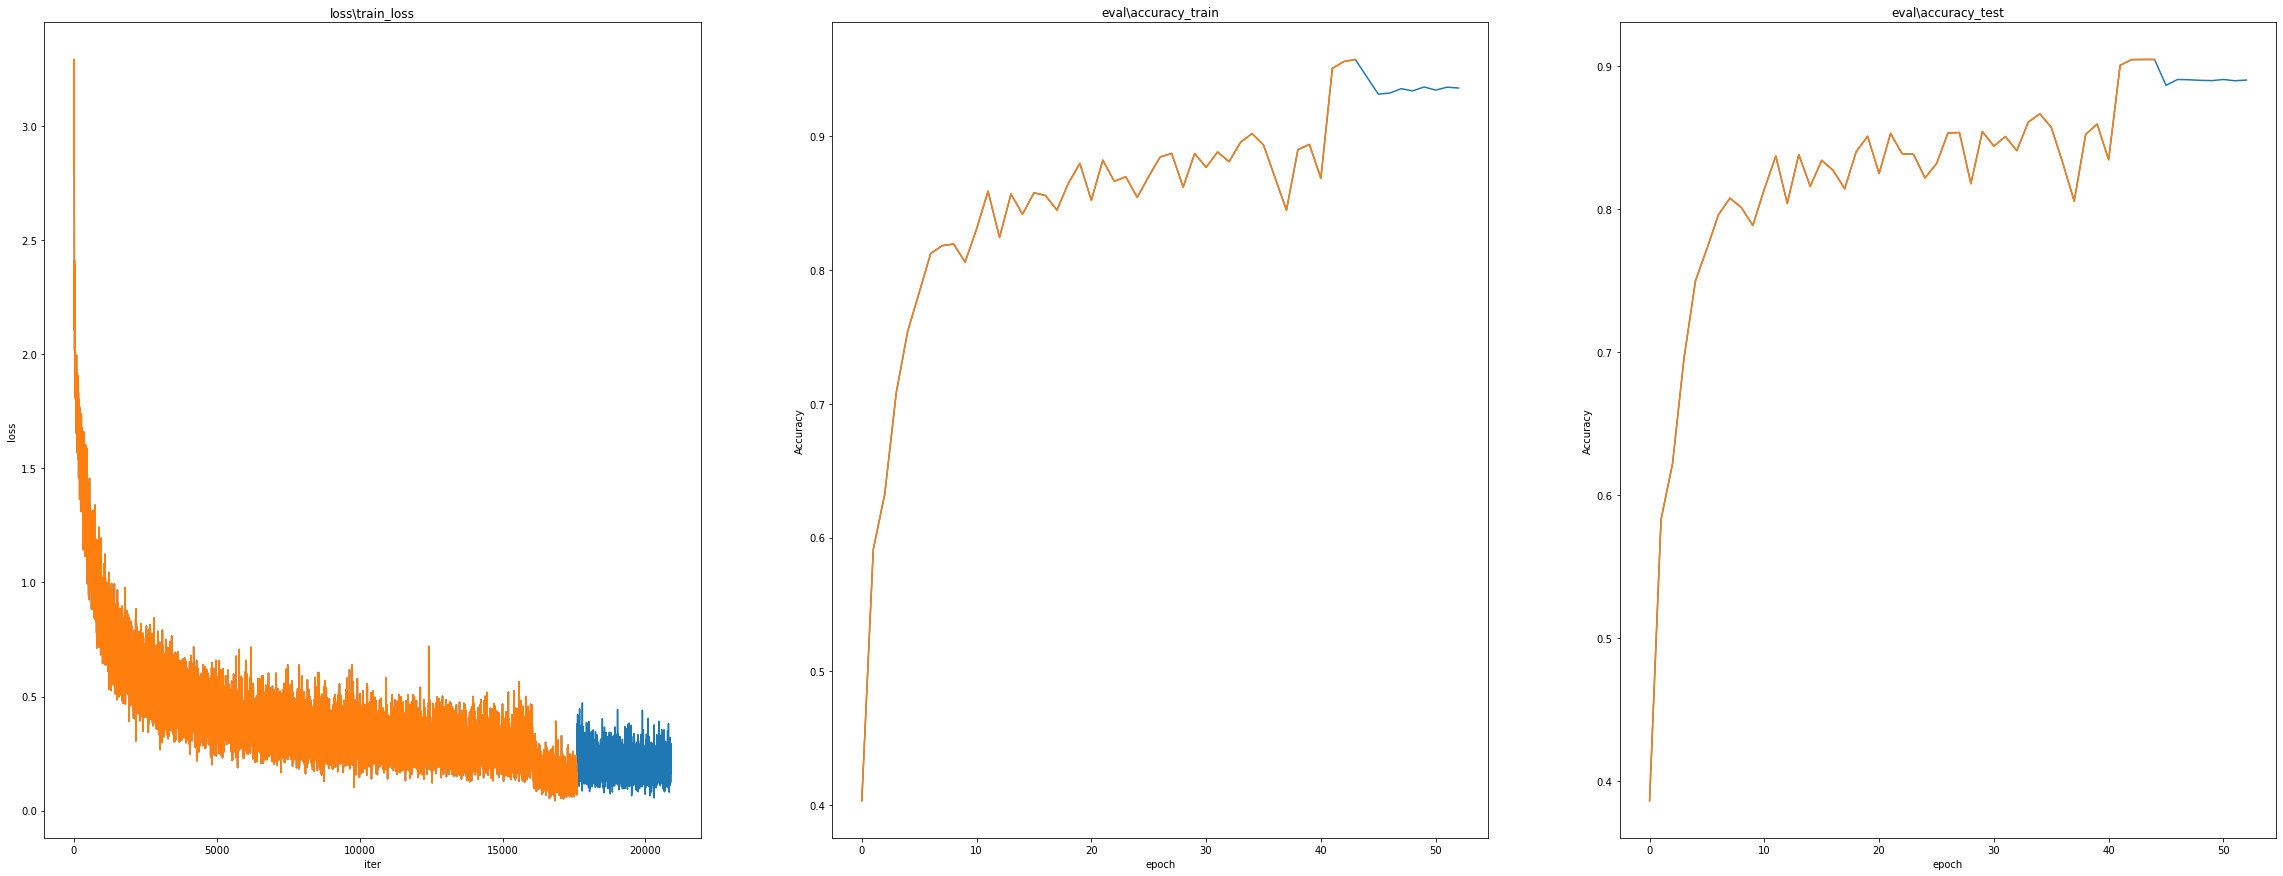

In [21]:
test.test(pruned_model,cfg)
fig, axes = plt.subplots(1,3,figsize=(40,15))


plot('loss\\train_loss_finetune', axes[0],cfg, 'iter')
plot('loss\\train_loss', axes[0],cfg, 'iter','loss')
plot('eval\\accuracy_train_finetune',axes[1],cfg,'epoch','Accuracy')
plot('eval\\accuracy_train',axes[1],cfg,'epoch','Accuracy')
plot('eval\\accuracy_test_finetune',axes[2],cfg,'epoch','Accuracy')
plot('eval\\accuracy_test',axes[2],cfg,'epoch','Accuracy')

plt.show()


Как можно заметить на графиках (оранжевый процесс обычного обучения, синий finetune с замороженными фильтрами свертки), дообучение позволяет достаточно хорошо поправить ситуацию после прунинга, так как после того как в модели свертки были заменены на центройды точность на тестовой выборке была около 72%. И также можно сделать вывод, что для finetune необходимо всего несколько эпох.


## 1. Замена всех сверточных фильтров сразу.
Проблема состоит в том, что если заменить все сверточных фильтры на центройды их кластеров одним моментов, то уход от отпимальных значений параметров будет слишком большим.

### Решение:
Для каждого слоя процесс прунинга и дообучения проводить отдельно, то есть сначала заменить фильтры на центройды соотвествущих кластеров для первого слоя свертки, заморозить эти фильтры и дообучить, потом подобное проделать со следующим слоем, только уже при дообучении уже фильтры будут заморожены у двух слоёв и так далее. Такая процедура позволит сети постепенно адаптироваться и итоговый результат должен будет получиться лучше, чем если бы фильтры были бы заменены во всех слоях одновременно.

## 2. Вектора, которые представляют сверточные фильтры, будут далеко друг от друга.
При кластеризации может получиться так, что вектор одного сверточного фильтра будет лежать слишком далеко от центройды кластера, к которому он присвоен, при том, что для него это будет самая ближайшая центройда из всех.

### Решение:
1. Увеличить количество кластеров, но не будет гарантии что подобная ситуация изменится или не повториться с другими векторами сверточных фильтров.
2. Добавить пороговое значение, и если евклидово расстояние между центройдом кластера и вектором сверточного фильтроа больше этого порога, то сверточный фильтр не заменяется. Но придется подбирать для каждого слоя отдельное значение порога.
3. Требовать при обучение, чтобы евклидова норма сверточных фильтров была близка к 1. Это решит проблемы с большими расстояниями между векторами сверточных фильтров и позволит перейти к косинусному расстоянию, которое, на мой взгляд, справится в контексте данной задачи лучше с задачей кластеризации и в получение центройды. Но как показано на гистрограмме норма векторов сверточных фильтров далека от 1 и поэтому косинусное расстояние использовать не стоит.

## 3. Потери важности значения каждого параметра.
При кластеризации значение каждого параметра не очень важно, а важна, в случае евклидова расстояния, их сумма. И в последствии может появить сильная потеря точности при замене фильтра на его центройду. Такая ситуация, к примеру, может возникнуть если вектора сверточных фильтров находятся в противоположных концах кластеров. И замена их обоих на цетройду кластера будет не совсем корректна.

### Решение:
Кластеризовать каждый элемент свертки по отдельности. К примеру, у нас есть 16 сверточных фильтров с 64 параметрами. И вместо того, чтобы провести одну кластеризацию на 10 кластеров 16 векторов длиной 64, мы проведем 64 кластереризации на 10 кластеров  16 векторов длиной 1 и из центройд будут собраны итоговые 10 центройд длины 64. Это позволит при поиске центройды с концетрировать внимание алгоритма только на одной компоненте вектора сверточного фильтра и в теории это должно дать более хороший результат при прунинге. Едиственное данная процедура будет не очень быстрой.

# Выявленные проблемы и предложения по их решению

## 1. Замена всех сверточных фильтров сразу.
Проблема состоит в том, что если заменить все сверточных фильтры на центройды их кластеров одним моментов, то уход от отпимальных значений параметров будет слишком большим.

### Решение:
Для каждого слоя процесс прунинга и дообучения проводить отдельно, то есть сначала заменить фильтры на центройды соотвествущих кластеров для первого слоя свертки, заморозить эти фильтры и дообучить, потом подобное проделать со следующим слоем, только уже при дообучении уже фильтры будут заморожены у двух слоёв и так далее. Такая процедура позволит сети постепенно адаптироваться и итоговый результат должен будет получиться лучше, чем если бы фильтры были бы заменены во всех слоях одновременно.

## 2. Вектора, которые представляют сверточные фильтры, будут далеко друг от друга.
При кластеризации может получиться так, что вектор одного сверточного фильтра будет лежать слишком далеко от центройды кластера, к которому он присвоен, при том, что для него это будет самая ближайшая центройда из всех.

### Решение:
1. Увеличить количество кластеров, но не будет гарантии что подобная ситуация изменится или не повториться с другими векторами сверточных фильтров.
2. Добавить пороговое значение, и если евклидово расстояние между центройдом кластера и вектором сверточного фильтроа больше этого порога, то сверточный фильтр не заменяется. Но придется подбирать для каждого слоя отдельное значение порога.
3. Требовать при обучение, чтобы евклидова норма сверточных фильтров была близка к 1. Это решит проблемы с большими расстояниями между векторами сверточных фильтров и позволит перейти к косинусному расстоянию, которое, на мой взгляд, справится в контексте данной задачи лучше с задачей кластеризации и в получение центройды. Но как показано на гистрограмме ниже норма векторов сверточных фильтров далека от 1(чем ближе синий к оранжевому, тем нормированее фильтры в сверточном слое) и поэтому косинусное расстояние использовать не стоит.


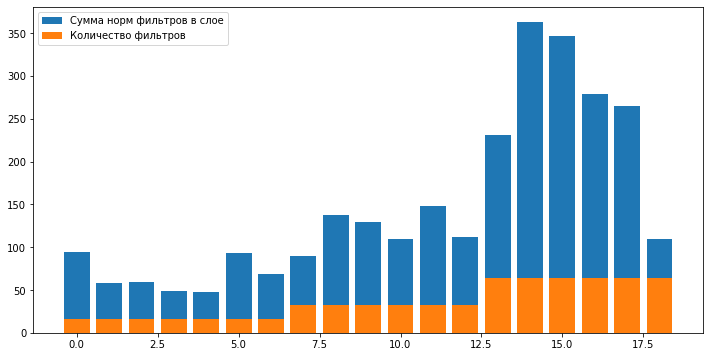

In [30]:

sum_filters = []
norm_filters = []
for name, module in model.named_modules():
    if isinstance(module,torch.nn.Conv2d):
        filters = module.weight.data.cpu().numpy()
        sum_filters.append(filters.shape[0])
        norm_filters.append(np.power(filters,2).sum())
fig, ax = plt.subplots()
ax.bar(np.arange(19),norm_filters,label='Сумма норм фильтров в слое')
ax.bar(np.arange(19), sum_filters,label='Количество фильтров')
ax.legend()
fig.set_figwidth(12)
fig.set_figheight(6)


plt.show()





## 3. Потери важности значения каждого параметра.
При кластеризации значение каждого параметра не очень важно, а важна, в случае евклидова расстояния, их сумма. И в последствии может появить сильная потеря точности при замене фильтра на его центройду. Такая ситуация, к примеру, может возникнуть если вектора сверточных фильтров находятся в противоположных концах кластеров. И замена их обоих на цетройду кластера будет не совсем корректна.

### Решение:
Кластеризовать каждый элемент свертки по отдельности. К примеру, у нас есть 16 сверточных фильтров с 64 параметрами. И вместо того, чтобы провести одну кластеризацию на 10 кластеров 16 векторов длиной 64, мы проведем 64 кластереризации на 10 кластеров  16 векторов длиной 1 и из центройд будут собраны итоговые 10 центройд длины 64. Это позволит при поиске центройды с концетрировать внимание алгоритма только на одной компоненте вектора сверточного фильтра и в теории это должно дать более хороший результат при прунинге. Едиственное данная процедура будет не очень быстрой.
